<a href="https://colab.research.google.com/github/M0rph3e/ift6758-project-main/blob/fengineering2/XGBoost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Motivation for the code and explanation [here](https://towardsdatascience.com/binary-classification-xgboost-hyperparameter-tuning-scenarios-by-non-exhaustive-grid-search-and-c261f4ce098d)

In [91]:
#import comet_ml in the top of your file
from comet_ml import Experiment
import os
from copy import deepcopy
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from skopt import BayesSearchCV
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
import xgboost as xgb
import pandas as pd
from ift6758.features.feature_engineering2 import SeasonDataSetTwo
from ift6758.metrics import plot_metrics
import random
random_state = 42

In [60]:
# COMET_API_KEY = 

#create an experiment with your api key
comet_exp = Experiment(api_key=os.environ.get('COMET_API_KEY'),
                project_name='milestone_2',
                workspace="morph-e",
                auto_param_logging=False
                )

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.


KeyboardInterrupt: 

In [92]:
def seed_everything(seed_value):
    random.seed(seed_value)
    np.random.seed(seed_value)
    os.environ['PYTHONHASHSEED'] = str(seed_value)
    
seed = 42
seed_everything(seed)

In [61]:
### Script to get the DataFrame and Split the data into train and test set for FE1
years = [2015,2016,2017,2018]


dataset = SeasonDataSetTwo(years)
df = dataset.get_features_2()

File with all events already Exists, loading from ../ift6758/data/PICKLE//2015_clean_all_events.pkl
File already Exists, loading from ../ift6758/data/PICKLE//2015_period_info.pkl
File with all events already Exists, loading from ../ift6758/data/PICKLE//2016_clean_all_events.pkl
File already Exists, loading from ../ift6758/data/PICKLE//2016_period_info.pkl
File with all events already Exists, loading from ../ift6758/data/PICKLE//2017_clean_all_events.pkl
File already Exists, loading from ../ift6758/data/PICKLE//2017_period_info.pkl
File with all events already Exists, loading from ../ift6758/data/PICKLE//2018_clean_all_events.pkl
File already Exists, loading from ../ift6758/data/PICKLE//2018_period_info.pkl


d:\masters\semester1\ift6758\ift6758-project-main\ift6758\features\feature_engineering2.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_masked['timeFromLastEvent'] = pd.to_datetime(df_masked['about.periodTime'], format='%M:%S') - pd.to_datetime(df_masked['last.event.about.periodTime'], format='%M:%S')
d:\masters\semester1\ift6758\ift6758-project-main\ift6758\features\feature_engineering2.py:93: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_masked['distanceFromLastEvent'] = df_masked.apply(
d:\mas

In [151]:
df.head()

,result.penaltySeverity,result.penaltyMinutes,gamePk,team.name,gamePeriod,coordinatesX,coordinatesY,shotType,emptyNet,result.strength.name,gameSeconds,shotDistance,shotAngle,isGoal,lastEventType,lastEventCoordinatesX,lastEventCoordinatesY,timeFromLastEvent,distanceFromLastEvent,rebound,speed,changeInShotAngle,angleSpeed
0,NaN,NaN,2015020001,Toronto Maple Leafs,1,-55.0,6.0,Wrist Shot,0,NaN,51.0,34.525353,10.007980,0,Hit,94.0,-34.0,11.0,154.275727,False,14.025066,0.000000,0.000000
1,NaN,NaN,2015020001,Toronto Maple Leafs,1,-79.0,0.0,Snap Shot,0,NaN,65.0,10.000000,0.000000,0,Giveaway,-37.0,-28.0,7.0,50.477718,False,7.211103,0.000000,0.000000
2,NaN,NaN,2015020001,Toronto Maple Leafs,1,-75.0,-1.0,Snap Shot,0,NaN,66.0,14.035669,-4.085617,0,Shot,-79.0,0.0,1.0,4.123106,True,4.123106,4.085617,4.085617
3,NaN,NaN,2015020001,Toronto Maple Leafs,1,-55.0,-36.0,Wrist Shot,0,NaN,113.0,49.517674,-46.636577,0,Hit,-91.0,35.0,18.0,79.605276,False,4.422515,0.000000,0.000000
4,NaN,NaN,2015020001,Toronto Maple Leafs,1,-61.0,-1.0,Tip-In,0,NaN,157.0,28.017851,-2.045408,0,Faceoff,-69.0,-22.0,5.0,22.472205,False,4.494441,0.000000,0.000000


In [152]:
features = ['gameSeconds','timeFromLastEvent','gamePeriod','shotType', 'shotAngle','coordinatesX','coordinatesY', 'shotDistance','lastEventType','lastEventCoordinatesX','lastEventCoordinatesY','distanceFromLastEvent', 'rebound','speed','changeInShotAngle']
label = ['isGoal']

In [153]:
df_exp = df[features+label]
print(df_exp.isna().any())
df_exp.head()


gameSeconds              False
timeFromLastEvent        False
gamePeriod               False
shotType                  True
shotAngle                 True
coordinatesX              True
coordinatesY              True
shotDistance              True
lastEventType            False
lastEventCoordinatesX     True
lastEventCoordinatesY     True
distanceFromLastEvent     True
rebound                  False
speed                     True
changeInShotAngle         True
isGoal                   False
dtype: bool


,gameSeconds,timeFromLastEvent,gamePeriod,shotType,shotAngle,coordinatesX,coordinatesY,shotDistance,lastEventType,lastEventCoordinatesX,lastEventCoordinatesY,distanceFromLastEvent,rebound,speed,changeInShotAngle,isGoal
0,51.0,11.0,1,Wrist Shot,10.007980,-55.0,6.0,34.525353,Hit,94.0,-34.0,154.275727,False,14.025066,0.000000,0
1,65.0,7.0,1,Snap Shot,0.000000,-79.0,0.0,10.000000,Giveaway,-37.0,-28.0,50.477718,False,7.211103,0.000000,0
2,66.0,1.0,1,Snap Shot,-4.085617,-75.0,-1.0,14.035669,Shot,-79.0,0.0,4.123106,True,4.123106,4.085617,0
3,113.0,18.0,1,Wrist Shot,-46.636577,-55.0,-36.0,49.517674,Hit,-91.0,35.0,79.605276,False,4.422515,0.000000,0
4,157.0,5.0,1,Tip-In,-2.045408,-61.0,-1.0,28.017851,Faceoff,-69.0,-22.0,22.472205,False,4.494441,0.000000,0


In [154]:
remove_nan_inf_features = ["shotAngle"]
df_exp[df_exp[remove_nan_inf_features].isin([np.nan,np.inf,-np.inf]).any(1)]

,gameSeconds,timeFromLastEvent,gamePeriod,shotType,shotAngle,coordinatesX,coordinatesY,shotDistance,lastEventType,lastEventCoordinatesX,lastEventCoordinatesY,distanceFromLastEvent,rebound,speed,changeInShotAngle,isGoal
14969,0.0,0.0,5,NaN,NaN,NaN,NaN,NaN,Shot,66.0,-2.0,NaN,True,NaN,NaN,0
21765,255.0,38.0,1,Snap Shot,NaN,-26.0,NaN,NaN,Giveaway,-64.0,40.0,NaN,False,NaN,0.0,0
40351,0.0,0.0,5,Backhand,NaN,NaN,NaN,NaN,Missed Shot,-66.0,6.0,NaN,False,NaN,0.0,0
42590,0.0,0.0,5,Wrist Shot,NaN,NaN,NaN,NaN,Shot,-64.0,3.0,NaN,True,NaN,NaN,0
105253,681.0,0.0,3,NaN,NaN,NaN,NaN,NaN,Shot,60.0,-14.0,NaN,True,NaN,NaN,1
124041,924.0,1.0,2,NaN,NaN,NaN,NaN,NaN,Shot,76.0,1.0,NaN,True,NaN,NaN,1
127890,185.0,17.0,4,Slap Shot,NaN,NaN,NaN,NaN,Faceoff,-69.0,-22.0,NaN,False,NaN,0.0,0
140159,1045.0,2.0,1,NaN,NaN,NaN,NaN,NaN,Shot,-53.0,-13.0,NaN,True,NaN,NaN,1
177220,57.0,35.0,3,Wrist Shot,NaN,NaN,NaN,NaN,Giveaway,71.0,-33.0,NaN,False,NaN,0.0,1
184516,1135.0,2.0,3,Wrist Shot,NaN,NaN,NaN,NaN,Shot,-50.0,13.0,NaN,True,NaN,NaN,1


In [155]:
remove_nan_inf_features= ["shotAngle","coordinatesX","coordinatesY","shotDistance","lastEventCoordinatesX","lastEventCoordinatesY","distanceFromLastEvent","speed","changeInShotAngle"]
df_exp = df_exp[~df_exp[remove_nan_inf_features].isin([np.nan,np.inf,-np.inf]).any(1)]

In [156]:
df_exp.isna().any()


gameSeconds              False
timeFromLastEvent        False
gamePeriod               False
shotType                  True
shotAngle                False
coordinatesX             False
coordinatesY             False
shotDistance             False
lastEventType            False
lastEventCoordinatesX    False
lastEventCoordinatesY    False
distanceFromLastEvent    False
rebound                  False
speed                    False
changeInShotAngle        False
isGoal                   False
dtype: bool

In [163]:
add_unknown_features = ["shotType"]
## Filled with unknown: To be done in advanced??
df_exp.loc[:,add_unknown_features] = df_exp.loc[:,add_unknown_features].fillna('Unknown')



In [164]:
df_exp.isna().any()


gameSeconds              False
timeFromLastEvent        False
gamePeriod               False
shotType                 False
shotAngle                False
coordinatesX             False
coordinatesY             False
shotDistance             False
lastEventType            False
lastEventCoordinatesX    False
lastEventCoordinatesY    False
distanceFromLastEvent    False
rebound                  False
speed                    False
changeInShotAngle        False
isGoal                   False
dtype: bool

In [165]:
categories = ['shotType','gamePeriod','lastEventType']
df_exp = pd.get_dummies(df_exp,columns=categories,dtype=int)


In [177]:
if 'rebound' in features:
    df_exp['rebound'] = df_exp['rebound'].astype(int)

In [178]:
pd.set_option('display.max_columns', None)
df_exp

,gameSeconds,timeFromLastEvent,shotAngle,coordinatesX,coordinatesY,shotDistance,lastEventCoordinatesX,lastEventCoordinatesY,distanceFromLastEvent,rebound,speed,changeInShotAngle,isGoal,shotType_Backhand,shotType_Deflected,shotType_Slap Shot,shotType_Snap Shot,shotType_Tip-In,shotType_Unknown,shotType_Wrap-around,shotType_Wrist Shot,gamePeriod_1,gamePeriod_2,gamePeriod_3,gamePeriod_4,gamePeriod_5,gamePeriod_6,lastEventType_Blocked Shot,lastEventType_Faceoff,lastEventType_Giveaway,lastEventType_Goal,lastEventType_Hit,lastEventType_Missed Shot,lastEventType_Penalty,lastEventType_Shot,lastEventType_Takeaway
0,51.0,11.0,10.007980,-55.0,6.0,34.525353,94.0,-34.0,154.275727,0,14.025066,0.000000,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
1,65.0,7.0,0.000000,-79.0,0.0,10.000000,-37.0,-28.0,50.477718,0,7.211103,0.000000,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2,66.0,1.0,-4.085617,-75.0,-1.0,14.035669,-79.0,0.0,4.123106,1,4.123106,4.085617,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,113.0,18.0,-46.636577,-55.0,-36.0,49.517674,-91.0,35.0,79.605276,0,4.422515,0.000000,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4,157.0,5.0,-2.045408,-61.0,-1.0,28.017851,-69.0,-22.0,22.472205,0,4.494441,0.000000,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
332736,885.0,7.0,23.838740,-46.0,19.0,47.010637,73.0,37.0,120.353646,0,17.193378,0.000000,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0
332737,922.0,31.0,30.256437,-77.0,7.0,13.892444,-57.0,34.0,33.600595,0,1.083890,0.000000,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0
332738,951.0,12.0,19.290046,-69.0,7.0,21.189620,-68.0,-29.0,36.013886,0,3.001157,0.000000,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0
332739,955.0,4.0,-9.462322,-65.0,-4.0,24.331050,-69.0,7.0,11.704700,1,2.926175,28.752368,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0


In [179]:
# df_exp =pd.concat([df_exp, shot_feature], axis=1).drop(columns='shotType')
df_exp.shape

(321664, 36)

In [180]:
val_ratio = 0.25
X= df_exp.drop(label,axis=1)
y= df_exp[label]
X_train, X_val, y_train, y_val = train_test_split(X, y,stratify=y,test_size=val_ratio)

In [181]:
print(y_train.sum()/X_train.shape[0],y_val.sum()/X_val.shape[0])

isGoal    0.090252
dtype: float64 isGoal    0.090256
dtype: float64


In [182]:
# X_train

In [188]:
# Apply XGB on distance and angle features from FE1
#objective='binary:logistic',
                        #   booster='gbtree',
                        #   eval_metric='auc',
                        #   tree_method='gpu_hist',
                        #   grow_policy='lossguide',
                        #   use_label_encoder=False,
                        #  random_state=random_state
                        
xgb1 = xgb.XGBClassifier(booster='gbtree')
xgb1.fit(X_train, y_train)



C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for examp

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=12,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [196]:
y_pred_val = xgb1.predict(X_val)
y_pred_val_scores = xgb1.predict_proba(X_val)[:,1]

In [197]:
y_pred_val_scores

array([0.0883827 , 0.10946027, 0.0313468 , ..., 0.08410891, 0.04933973,
       0.11028685], dtype=float32)

In [190]:
experiment="XGB base"

              precision    recall  f1-score   support

           0       0.91      1.00      0.95     73158
           1       0.52      0.03      0.05      7258

    accuracy                           0.91     80416
   macro avg       0.71      0.51      0.50     80416
weighted avg       0.88      0.91      0.87     80416



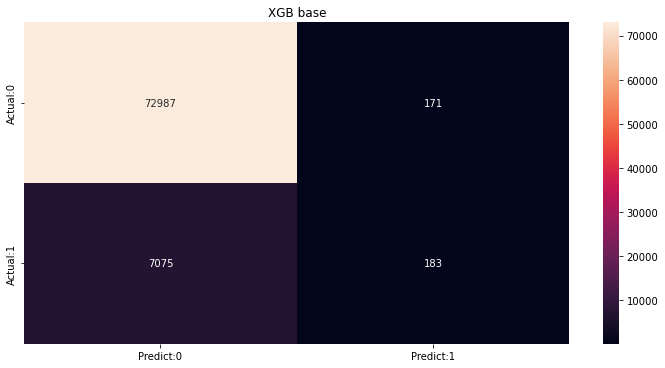

In [191]:
plot_metrics.plotConfusion(y_val,y_pred_val,title=experiment)


In [194]:
y_pred_val

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

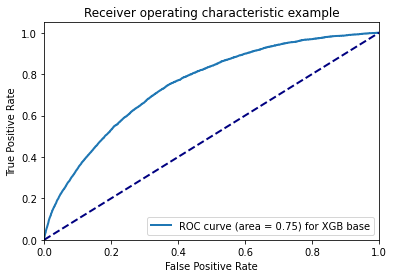

In [198]:
plot_metrics.plot_roc([y_val],[y_pred_val_scores],plot_labels=[experiment])

In [ ]:
###Script to perfrom generation of Graphs


In [ ]:
### Script to get the DataFrame and Split the data into train and test set for FE2

In [ ]:
### Apply XGB on features from FE2
#dictionary for collecting results
results_dict = {}

#obtaining default parameters by calling .fit() to XGBoost model instance
xgb2 = xgb.XGBClassifier(objective='binary:logistic',
                          booster='gbtree',
                          eval_metric='auc',
                          tree_method='gpu_hist',
                          grow_policy='lossguide',
                          use_label_encoder=False,
                         random_state=random_state
                        )
xgb2.fit(X, y)

#extracting default parameters from benchmark model
default_params = {}
gparams = xgb2.get_params()

#default parameters have to be wrapped in lists - even single values - so GridSearchCV can take them as inputs
for key in gparams.keys():
    gp = gparams[key]
    default_params[key] = [gp]

#benchmark model. Grid search is not performed, since only single values are provided as parameter grid.
#However, cross-validation is still executed
clf0 = GridSearchCV(estimator=xgb2, scoring='accuracy', param_grid=default_params, return_train_score=True, verbose=1, cv=3)
clf0.fit(X_train, y_train.values.ravel())

#results dataframe
df = pd.DataFrame(clf0.cv_results_)

#best parameters
bp = clf0.best_params_

#storing computed values in results dictionary
results_dict['xgb2'] = {'iterable_parameter': np.nan,
                         'classifier': deepcopy(clf0),
                         'cv_results': df.copy(),
                         'best_params': bp}



y_pred = clf0.predict(X_test)
y_proba = clf0.predict_proba(X_test)

In [ ]:
##Hyperparameter Tuning
#creating deepcopy of default parameters before manipulations
params = deepcopy(default_params)

#setting grid of selected parameters for iteration
param_grid = {'gamma': [0,0.1,0.2,0.4,0.8,1.6,3.2,6.4,12.8,25.6,51.2,102.4, 200],
              'learning_rate': [0.01, 0.03, 0.06, 0.1, 0.15, 0.2, 0.25, 0.3, 0.4, 0.5, 0.6, 0.7],
              'max_depth': [5,6,7,8,9,10,11,12,13,14],
              'n_estimators': [50,65,80,100,115,130,150],
              'reg_alpha': [0,0.1,0.2,0.4,0.8,1.6,3.2,6.4,12.8,25.6,51.2,102.4,200],
              'reg_lambda': [0,0.1,0.2,0.4,0.8,1.6,3.2,6.4,12.8,25.6,51.2,102.4,200]}

#No. of jobs
bcvj = int(np.cumsum([len(x) for x in param_grid.values()])[-1])

#unwrapping list values of default parameters
default_params_xgb = {}

for key in default_params.keys():
    default_params_xgb[key] = default_params[key][0]

#providing default parameters to xgbc model, before randomized search cross-validation
xgb3 = xgb.XGBClassifier(**default_params_xgb)

clf = BayesSearchCV(estimator=xgb3, search_spaces=param_grid, n_iter=bcvj, scoring='accuracy', cv=3, return_train_score=True, verbose=3)
clf.fit(X_train, y_train.values.ravel())

#results dataframe
df = pd.DataFrame(clf.cv_results_)

#best parameters
bp = clf.best_params_

#storing computed values in results dictionary
results_dict['xgb3'] = {'classifier': deepcopy(clf),
                            'cv_results': df.copy(),
                            'best_params': bp}


y_pred = clf.predict(X_test)
y_proba = clf.predict_proba(X_test)

In [ ]:
###Script to perfrom generation of Graphs